Tarea 3 - Gabriel García

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
import torchvision
import torchsummary

In [ ]:
!pip install torchmetrics
import torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 419 kB 14.8 MB/s 


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
### Descripción del conjunto de entrenamiento ###
Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
### Dimensiones de un ejemplo del dataset ###
(32, 32, 3)
### Descripción del conjunto de evaluación ###
Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
Label de la imágen 0: 6
Label de la imágen 1: 9
Label de la imágen 2: 9
Label de la imágen 3: 4
Label de la imágen 4: 1
Label de la imágen 5: 1
Label de la imágen 6: 2
Label de la imágen 7: 7
Label de la imágen 8: 8


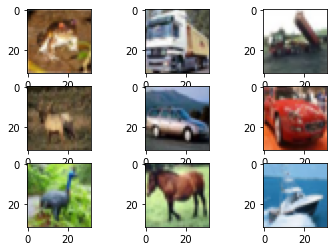

In [ ]:
train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True)
test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True)

print("### Descripción del conjunto de entrenamiento ###")
print(train_set)
print("### Dimensiones de un ejemplo del dataset ###")
print(np.shape(train_set[0][0]))
print("### Descripción del conjunto de evaluación ###")
print(test_set)

# Ploteo algunas imagenes del dataset y sus etiquetas
for i in range(9):
  image, label = train_set[i]
  plt.subplot(331 + i)
  plt.imshow(image, cmap=plt.get_cmap('gray'))
  print("Label de la imágen {}: {}".format(i, label))

plt.show()

In [ ]:
data_transforms = torchvision.transforms.Compose([
                    torchvision.transforms.Resize(size=(224, 224)),
                    torchvision.transforms.ToTensor(),
                    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                  ])

train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform = data_transforms)
test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform = data_transforms)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
valid_set_size = 5000

train_set, valid_set = torch.utils.data.random_split(train_set, [len(train_set) - valid_set_size, valid_set_size])

print("Tamaño del conjunto de entrenamiento: {}".format(len(train_set)))
print("Tamaño del conjunto de validación: {}".format(len(valid_set)))

Tamaño del conjunto de entrenamiento: 45000
Tamaño del conjunto de validación: 5000


In [ ]:

train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=32, shuffle=True)

In [ ]:
# Carga de modelo base

vgg11_model = torchvision.models.vgg11(pretr ained=True)

vgg11_model.to("cuda")

torchsummary.summary(vgg11_model, input_size=(3, 224, 224))
vgg11_model.modules

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
         MaxPool2d-3         [-1, 64, 112, 112]               0
            Conv2d-4        [-1, 128, 112, 112]          73,856
              ReLU-5        [-1, 128, 112, 112]               0
         MaxPool2d-6          [-1, 128, 56, 56]               0
            Conv2d-7          [-1, 256, 56, 56]         295,168
              ReLU-8          [-1, 256, 56, 56]               0
            Conv2d-9          [-1, 256, 56, 56]         590,080
             ReLU-10          [-1, 256, 56, 56]               0
        MaxPool2d-11          [-1, 256, 28, 28]               0
           Conv2d-12          [-1, 512, 28, 28]       1,180,160
             ReLU-13          [-1, 512, 28, 28]               0
           Conv2d-14          [-1, 512,

<bound method Module.modules of VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0

In [ ]:
# Congelamos parámetros
for param in vgg11_model.parameters():
    param.requires_grad = False

In [ ]:
# Cambiamos última capa
last_layer_in_features = vgg11_model.classifier[-1].in_features
# Asignamos 10 salidas a la última capa del convnext_tiny. 
vgg11_model.classifier[-1] = torch.nn.Linear(in_features=last_layer_in_features, out_features=10)

In [ ]:
# Optimizador, agregando un cero más al learning rate

optimizer_ft = torch.optim.Adam(vgg11_model.parameters(), lr=0.0001)

criterion = torch.nn.CrossEntropyLoss()

In [ ]:
def train(model, criterion, optimizer, train_loader, valid_loader, epochs):

    accuracy_metric = torchmetrics.Accuracy()

    if torch.cuda.is_available():
        model.to("cuda")
        accuracy_metric.to("cuda")

    train_loss = []
    train_acc = []
    valid_loss = []
    valid_acc = []

    for epoch in range(epochs):

        # Pongo el modelo en modo entrenamiento
        model.train()

        epoch_train_loss = 0.0
        epoch_train_accuracy = 0.0

        for train_data, train_target in train_loader:
            
            if torch.cuda.is_available():
                train_data = train_data.to("cuda")
                train_target = train_target.to("cuda")

            optimizer.zero_grad()
            output = model(train_data)
            loss = criterion(output, train_target)
            epoch_train_loss += loss.item()
            loss.backward()
            optimizer.step()

            accuracy = accuracy_metric(output, train_target)
            epoch_train_accuracy += accuracy.item()

        epoch_train_loss = epoch_train_loss / len(train_loader)
        epoch_train_accuracy = epoch_train_accuracy / len(train_loader)
        train_loss.append(epoch_train_loss)
        train_acc.append(epoch_train_accuracy)

        # Pongo el modelo en modo testeo
        model.eval()

        epoch_valid_loss = 0.0
        epoch_valid_accuracy = 0.0

        for valid_data, valid_target in valid_loader:
            if torch.cuda.is_available():
                valid_data = valid_data.to("cuda")
                valid_target = valid_target.to("cuda")

            output = model(valid_data)
            epoch_valid_loss += criterion(output, valid_target).item()
            epoch_valid_accuracy += accuracy_metric(output, valid_target).item()
            
        epoch_valid_loss = epoch_valid_loss / len(valid_loader)
        epoch_valid_accuracy = epoch_valid_accuracy / len(valid_loader)
        valid_loss.append(epoch_valid_loss)
        valid_acc.append(epoch_valid_accuracy)

        print("Epoch: {}/{} - Train loss {:.6f} - Train Accuracy {:.6f} - Valid Loss {:.6f} - Valid Accuracy {:.6f}".format(
        epoch+1, epochs, epoch_train_loss, epoch_train_accuracy, epoch_valid_loss, epoch_valid_accuracy))

    history = {}
    history["train_loss"] = train_loss
    history["train_acc"] = train_acc
    history["valid_loss"] = valid_loss
    history["valid_acc"] = valid_acc

    return model, history

In [ ]:
result_model, history = train(vgg11_model, criterion, optimizer_ft, train_loader, valid_loader, 10)


Epoch: 1/10 - Train loss 0.876913 - Train Accuracy 0.717795 - Valid Loss 0.603133 - Valid Accuracy 0.804936
Epoch: 2/10 - Train loss 0.621767 - Train Accuracy 0.785648 - Valid Loss 0.539203 - Valid Accuracy 0.819467
Epoch: 3/10 - Train loss 0.584207 - Train Accuracy 0.795642 - Valid Loss 0.510996 - Valid Accuracy 0.829021
Epoch: 4/10 - Train loss 0.562588 - Train Accuracy 0.802061 - Valid Loss 0.487167 - Valid Accuracy 0.839570
Epoch: 5/10 - Train loss 0.552616 - Train Accuracy 0.805126 - Valid Loss 0.479940 - Valid Accuracy 0.838774
Epoch: 6/10 - Train loss 0.542913 - Train Accuracy 0.807547 - Valid Loss 0.472937 - Valid Accuracy 0.840764
Epoch: 7/10 - Train loss 0.533334 - Train Accuracy 0.811256 - Valid Loss 0.467194 - Valid Accuracy 0.839769
Epoch: 8/10 - Train loss 0.529421 - Train Accuracy 0.811389 - Valid Loss 0.457313 - Valid Accuracy 0.847532
Epoch: 9/10 - Train loss 0.524602 - Train Accuracy 0.813988 - Valid Loss 0.459568 - Valid Accuracy 0.843551
Epoch: 10/10 - Train loss 0.

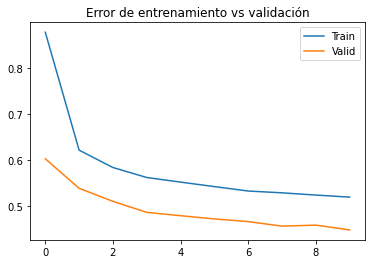

In [ ]:
plt.plot(history["train_loss"])
plt.plot(history["valid_loss"])
plt.title("Error de entrenamiento vs validación")
plt.legend(['Train', 'Valid'])
plt.show()

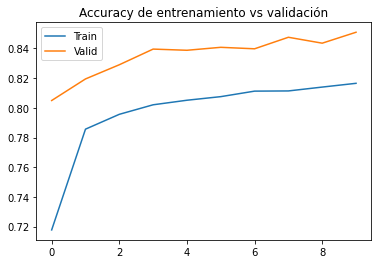

In [ ]:
plt.plot(history["train_acc"])
plt.plot(history["valid_acc"])
plt.title("Accuracy de entrenamiento vs validación")
plt.legend(['Train', 'Valid'])
plt.show()

In [ ]:
# Realizo el paso de evaluación computando error y accuracy
test_loss = 0.0
test_accuracy = 0.0

accuracy_metric = torchmetrics.Accuracy()

if torch.cuda.is_available():
        vgg11_model.to("cuda")
        accuracy_metric.to("cuda")

for test_data, test_target in test_loader:
  if torch.cuda.is_available():
        test_data, test_target = test_data.cuda(), test_target.cuda()
  output = vgg11_model(test_data)
  test_loss += criterion(output, test_target).item()
  test_accuracy += accuracy_metric(output, test_target).item()

test_loss = test_loss / len(test_loader)
test_accuracy = test_accuracy / len(test_loader)

print("El modelo logró un error de {:.6f} y una accuracy de {:.6f}".format(test_loss, test_accuracy))

El modelo logró un error de 0.471808 y una accuracy de 0.839357


A pesar de solo entrenar durante 10 épocas la red neuronal. El enfoque de emplear transfer learning mejoró notablemente el performance (tanto en error como en accuracy) del modelo tanto en entrenamiento como en validación, comparado con el modelo entrenado en la tarea2 entrenado por 40 épocas. Debido a que esta red es algo más compleja, y que el LR debe ser más pequeño porque empleamos transfer learning, el entrenamiento de cada época tardó relativamente más, comparado con el entrenamiento en la tarea2. Por último, se observa una buena generalización del modelo en datos de validación, y al probar con el set de testeo, se obtiene un accuracy de casi 0.84.

2) Realice el entrenamiento de la misma red seleccionada en el punto 1, sin partir de pesos preentrenados en esta oportunidad y sin congelar capas. A que resultados llega y como los explica?

In [ ]:
# Cargamos dataset sin resize ni normalización, debido a que no utilizaremos pesos preentrenados
data_transforms_not_pretrained = torchvision.transforms.Compose([
                    torchvision.transforms.ToTensor(),
                  ])

train_set_not_pretrained = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform = data_transforms_not_pretrained)
test_set_not_pretrained = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform = data_transforms_not_pretrained)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# Creamos set de validación

valid_set_size = 5000

train_set_not_pretrained, valid_set_not_pretrained = torch.utils.data.random_split(train_set_not_pretrained, [len(train_set_not_pretrained) - valid_set_size, valid_set_size])

print("Tamaño del conjunto de entrenamiento: {}".format(len(train_set_not_pretrained)))
print("Tamaño del conjunto de validación: {}".format(len(valid_set_not_pretrained)))


Tamaño del conjunto de entrenamiento: 45000
Tamaño del conjunto de validación: 5000


In [ ]:
train_loader_not_pretrained  = torch.utils.data.DataLoader(train_set_not_pretrained , batch_size=32, shuffle=True)
valid_loader_not_pretrained  = torch.utils.data.DataLoader(valid_set_not_pretrained , batch_size=32, shuffle=True)
test_loader_not_pretrained  = torch.utils.data.DataLoader(test_set_not_pretrained , batch_size=32, shuffle=True)

In [ ]:
# Carga de modelo base sin pre entrenar los pesos de la red (por default pretrained = False)

vgg11_not_pretrained_model = torchvision.models.vgg11()

vgg11_not_pretrained_model.to("cuda")

torchsummary.summary(vgg11_not_pretrained_model, input_size=(3, 32, 32))
vgg11_not_pretrained_model.modules

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
              ReLU-2           [-1, 64, 32, 32]               0
         MaxPool2d-3           [-1, 64, 16, 16]               0
            Conv2d-4          [-1, 128, 16, 16]          73,856
              ReLU-5          [-1, 128, 16, 16]               0
         MaxPool2d-6            [-1, 128, 8, 8]               0
            Conv2d-7            [-1, 256, 8, 8]         295,168
              ReLU-8            [-1, 256, 8, 8]               0
            Conv2d-9            [-1, 256, 8, 8]         590,080
             ReLU-10            [-1, 256, 8, 8]               0
        MaxPool2d-11            [-1, 256, 4, 4]               0
           Conv2d-12            [-1, 512, 4, 4]       1,180,160
             ReLU-13            [-1, 512, 4, 4]               0
           Conv2d-14            [-1, 51

<bound method Module.modules of VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0

In [ ]:
# Optimizador, agregando un cero más al learning rate

optimizer_not_pretained_ft = torch.optim.Adam(vgg11_not_pretrained_model.parameters(), lr=0.0001)

criterion = torch.nn.CrossEntropyLoss()

In [ ]:
# Cambiamos última capa para definir 10 salidas

last_layer_in_features = vgg11_not_pretrained_model.classifier[-1].in_features
vgg11_not_pretrained_model.classifier[-1] = torch.nn.Linear(in_features=last_layer_in_features, out_features=10)

In [ ]:
vgg11_not_pretrained_model.modules

<bound method Module.modules of VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0

In [ ]:
result_model, history = train(vgg11_not_pretrained_model, criterion, optimizer_not_pretained_ft, train_loader_not_pretrained, valid_loader_not_pretrained, 10)

Epoch: 1/10 - Train loss 1.594378 - Train Accuracy 0.392724 - Valid Loss 1.229885 - Valid Accuracy 0.559315
Epoch: 2/10 - Train loss 1.101003 - Train Accuracy 0.605899 - Valid Loss 1.025483 - Valid Accuracy 0.633559
Epoch: 3/10 - Train loss 0.873987 - Train Accuracy 0.690876 - Valid Loss 0.928749 - Valid Accuracy 0.683917
Epoch: 4/10 - Train loss 0.689136 - Train Accuracy 0.758262 - Valid Loss 0.832531 - Valid Accuracy 0.723925
Epoch: 5/10 - Train loss 0.529135 - Train Accuracy 0.816409 - Valid Loss 0.840192 - Valid Accuracy 0.720143
Epoch: 6/10 - Train loss 0.390911 - Train Accuracy 0.865139 - Valid Loss 0.912706 - Valid Accuracy 0.714172
Epoch: 7/10 - Train loss 0.282562 - Train Accuracy 0.902918 - Valid Loss 1.002815 - Valid Accuracy 0.726314
Epoch: 8/10 - Train loss 0.218429 - Train Accuracy 0.926017 - Valid Loss 1.056309 - Valid Accuracy 0.731688
Epoch: 9/10 - Train loss 0.169712 - Train Accuracy 0.942853 - Valid Loss 1.119828 - Valid Accuracy 0.727508
Epoch: 10/10 - Train loss 0.

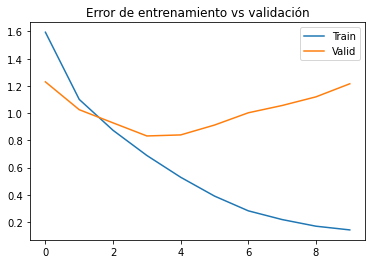

In [ ]:
plt.plot(history["train_loss"])
plt.plot(history["valid_loss"])
plt.title("Error de entrenamiento vs validación")
plt.legend(['Train', 'Valid'])
plt.show()

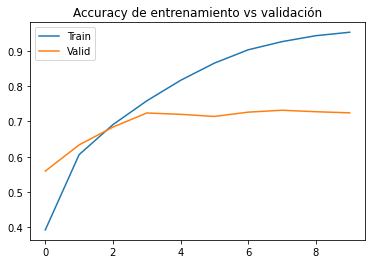

In [ ]:
plt.plot(history["train_acc"])
plt.plot(history["valid_acc"])
plt.title("Accuracy de entrenamiento vs validación")
plt.legend(['Train', 'Valid'])
plt.show()

In [ ]:
# Realizo el paso de evaluación computando error y accuracy
test_loss = 0.0
test_accuracy = 0.0

accuracy_metric = torchmetrics.Accuracy()

if torch.cuda.is_available():
        vgg11_not_pretrained_model.to("cuda")
        accuracy_metric.to("cuda")

for test_data, test_target in test_loader_not_pretrained:
  if torch.cuda.is_available():
        test_data, test_target = test_data.cuda(), test_target.cuda()
  output = vgg11_not_pretrained_model(test_data)
  test_loss += criterion(output, test_target).item()
  test_accuracy += accuracy_metric(output, test_target).item()

test_loss = test_loss / len(test_loader)
test_accuracy = test_accuracy / len(test_loader)

print("El modelo logró un error de {:.6f} y una accuracy de {:.6f}".format(test_loss, test_accuracy))

El modelo logró un error de 1.243641 y una accuracy de 0.716953


Inicialmente, se deben cambiar ciertas consideraciones iniciales, como la normalización y el resize, ya que estás son recomendadas cuando se emplean los pesos preentrenados. El modelo inicia con resultados peores comparados con el enfoque con pesos preentrenados, ya que tiene que aprender inicialmente de los datos, pero a medida que avanza va mejorando el accuracy y disminuyendo el error únicamente en el set de entrenamiento, por lo que podemos decir que el modelo cae en un sobreentrenamiento y al final, probándolo con el set de test, se obtiene solo .716 de accuracy. 

Los resultados hacen mucho sentido, utilizando los modelos pre-entrenados (y siempre y cuando los datos sean similares a nuestro problema objetivo) podemos encontrar patrones mucho más complejos encontrados entre los datos tras el entrenamiento de la red en ImageNet, pero aplicadas al caso partícular del dataset de CIFAR10, lo anterior hace que el modelo empiece con un performance más alto y evita que se sobreentrene el modelo, pero también hace que el performance aumente paulatinamente tras cada época. Mientras que cuando no utilizamos los pesos pre-entrenados, estamos forzando al modelo a aprender únicamente de nuestro set de datos, lo que al final puede lograr mejores resultados en entrenamiento, pero no tan buenos en validación y/o test, tal y como se evidenció en los resultados finales.